## ML Notebook Debugging Exercise

Work in progress

In [3]:
# =============================
# 0. Imports
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns


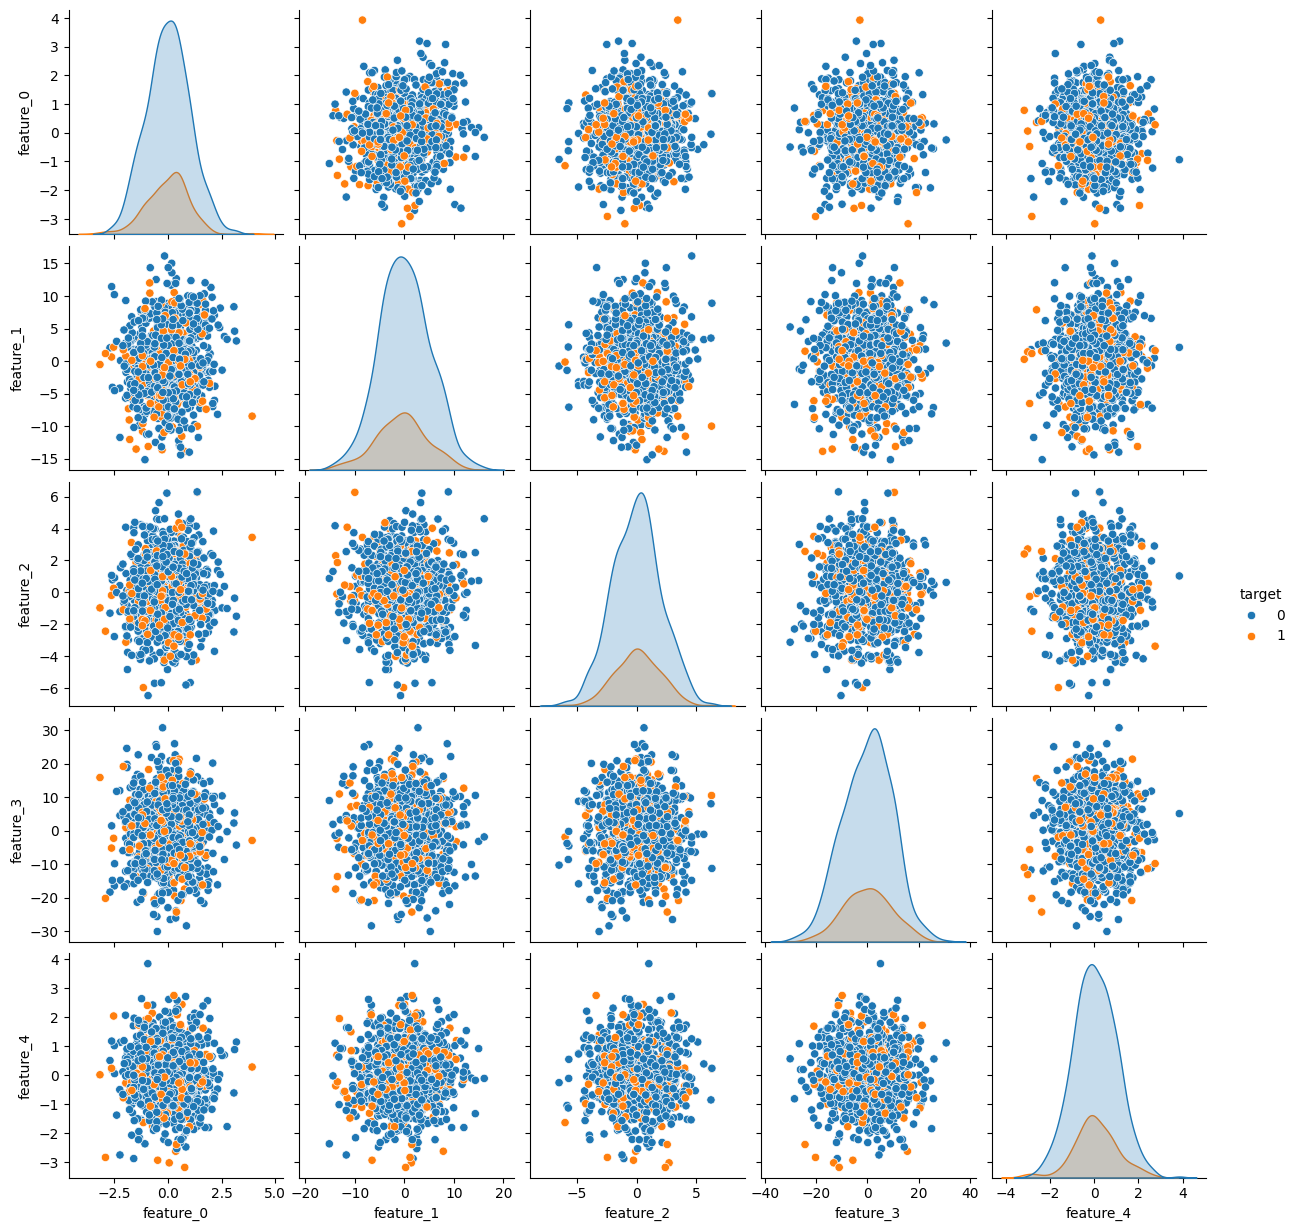

In [4]:

# =============================
# 1. Generate synthetic dataset
# =============================
np.random.seed(42)

n_samples = 1000
n_features = 5

# Features: random numbers, some skewed
X = np.random.randn(n_samples, n_features) * np.array([1, 5, 2, 10, 1])
# Introduce correlation to make it more realistic
X[:, 1] += X[:, 0] * 0.5

# Labels: imbalance
y = (np.random.rand(n_samples) < 0.2).astype(int)

# Convert to DataFrame for convenience
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['target'] = y

# Visual inspection
sns.pairplot(df, hue='target')
plt.show()


Epoch 0: train_loss=0.6931, val_loss=0.6376
Epoch 5: train_loss=6.4002, val_loss=3.6759
Epoch 10: train_loss=3.8880, val_loss=6.3627
Epoch 15: train_loss=5.7370, val_loss=4.1809
Epoch 20: train_loss=4.4553, val_loss=5.4222
Epoch 25: train_loss=4.9630, val_loss=4.5117
Epoch 30: train_loss=4.5766, val_loss=4.6314
Epoch 35: train_loss=4.4139, val_loss=4.3399
Epoch 40: train_loss=4.3369, val_loss=4.1800
Epoch 45: train_loss=4.0772, val_loss=4.0160


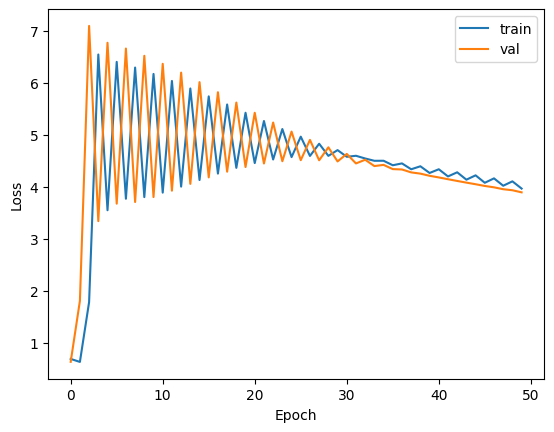

[Fixed] Epoch 0: train_loss=1.8111, val_loss=1.8682
[Fixed] Epoch 10: train_loss=1.8070, val_loss=1.8640
[Fixed] Epoch 20: train_loss=1.8028, val_loss=1.8599
[Fixed] Epoch 30: train_loss=1.7987, val_loss=1.8558
[Fixed] Epoch 40: train_loss=1.7945, val_loss=1.8516
[Fixed] Epoch 50: train_loss=1.7904, val_loss=1.8475
[Fixed] Epoch 60: train_loss=1.7863, val_loss=1.8434
[Fixed] Epoch 70: train_loss=1.7821, val_loss=1.8393
[Fixed] Epoch 80: train_loss=1.7780, val_loss=1.8351
[Fixed] Epoch 90: train_loss=1.7739, val_loss=1.8310


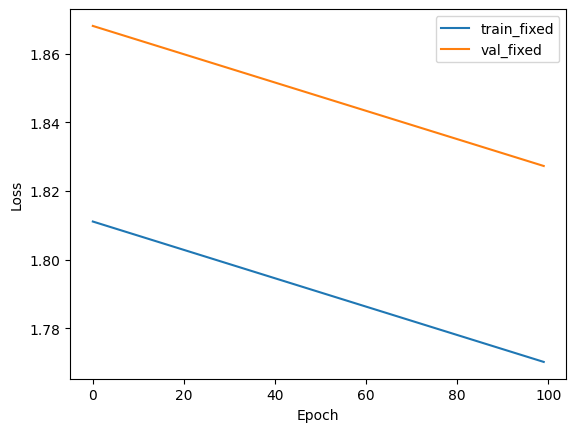

Validation accuracy: 0.7950
Validation ROC AUC: 0.4761
Confusion Matrix:
[[159   0]
 [ 41   0]]


/var/folders/6l/zgnfrkfn63qcyllsbv5jpy800000gn/T/ipykernel_87320/2672143844.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [5]:

# =============================
# 2. Train/Validation Split
# =============================
X = df.drop(columns=['target']).values
y = df['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =============================
# 3. Manual Logistic Regression Training Loop (Buggy)
# =============================
# Initialize weights
w = np.zeros(n_features)
b = 0
lr = 1.0  # HIGH learning rate - will cause exploding loss

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(logits, y_true):
    # BUG: wrong loss, should use binary cross-entropy
    # return np.mean(logits)  # <- buggy
    eps = 1e-8
    return -np.mean(y_true*np.log(sigmoid(logits)+eps) + (1-y_true)*np.log(1-sigmoid(logits)+eps))

n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # =============================
    # BUG: missing shuffle each epoch
    # =============================
    
    # Forward pass
    logits = X_train.dot(w) + b
    
    # Compute loss
    loss = compute_loss(logits, y_train)
    train_losses.append(loss)
    
    # Compute gradient manually
    preds = sigmoid(logits)
    grad_w = X_train.T.dot(preds - y_train) / len(y_train)
    grad_b = np.mean(preds - y_train)
    
    # Gradient step
    w -= lr * grad_w
    b -= lr * grad_b
    
    # Validation loss
    val_logits = X_val.dot(w) + b
    val_loss = compute_loss(val_logits, y_val)
    val_losses.append(val_loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: train_loss={loss:.4f}, val_loss={val_loss:.4f}")

# =============================
# 4. Plot losses
# =============================
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# =============================
# 5. Debugging / Fixes
# =============================

# 5.1 Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 5.2 Reduce learning rate
lr = 0.01

# 5.3 Fix compute_loss is already corrected above

# 5.4 Add shuffle
n_epochs = 100
train_losses_fixed = []
val_losses_fixed = []

for epoch in range(n_epochs):
    # Shuffle
    idx = np.random.permutation(len(X_train_scaled))
    X_train_shuffled = X_train_scaled[idx]
    y_train_shuffled = y_train[idx]
    
    # Forward pass
    logits = X_train_shuffled.dot(w) + b
    
    # Compute loss
    loss = compute_loss(logits, y_train_shuffled)
    train_losses_fixed.append(loss)
    
    # Gradients
    preds = sigmoid(logits)
    grad_w = X_train_shuffled.T.dot(preds - y_train_shuffled) / len(y_train_shuffled)
    grad_b = np.mean(preds - y_train_shuffled)
    
    # Update
    w -= lr * grad_w
    b -= lr * grad_b
    
    # Validation loss
    val_logits = X_val_scaled.dot(w) + b
    val_loss = compute_loss(val_logits, y_val)
    val_losses_fixed.append(val_loss)
    
    if epoch % 10 == 0:
        print(f"[Fixed] Epoch {epoch}: train_loss={loss:.4f}, val_loss={val_loss:.4f}")

plt.plot(train_losses_fixed, label='train_fixed')
plt.plot(val_losses_fixed, label='val_fixed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# =============================
# 6. Evaluate metrics
# =============================
y_pred_prob = sigmoid(X_val_scaled.dot(w) + b)
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
cm = confusion_matrix(y_val, y_pred)

print(f"Validation accuracy: {acc:.4f}")
print(f"Validation ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

# =============================
# 7. Optional: Early stopping
# =============================
best_val_loss = np.inf
patience = 5
counter = 0
best_w = w.copy()
best_b = b

train_losses_es = []
val_losses_es = []

for epoch in range(n_epochs):
    idx = np.random.permutation(len(X_train_scaled))
    X_train_shuffled = X_train_scaled[idx]
    y_train_shuffled = y_train[idx]
    
    logits = X_train_shuffled.dot(w) + b
    loss = compute_loss(logits, y_train_shuffled)
    train_losses_es.append(loss)
    
    preds = sigmoid(logits)
    grad_w = X_train_shuffled.T.dot(preds - y_train_shuffled) / len(y_train_shuffled)
    grad_b = np.mean(preds - y_train_shuffled)
    
    w -= lr * grad_w
    b -= lr * grad_b
    
    val_logits = X_val_scaled.dot(w) + b
    val_loss = compute_loss(val_logits, y_val)
    val_losses_es.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_w = w.copy()
        best_b = b
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            w = best_w
            b = best_b
            break

# =============================
# 8. Monitoring ideas for production
# =============================
# - input drift: check if feature distributions change over time
# - label drift: check if label distribution changes
# - calibration: make sure predicted probabilities match observed outcomes
# - latency p99: track 99th percentile inference time
# - A/B experiment design: split traffic to test model vs control

# =============================
# 9. Unit test example for sigmoid
# =============================
def test_sigmoid():
    x = np.array([-1000, 0, 1000])
    y = sigmoid(x)
    assert np.allclose(y, [0, 0.5, 1], atol=1e-4)

test_sigmoid()
